In [1]:
import nltk, re
import pandas as pd
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import movie_reviews as mr
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

stop_words = stopwords.words('english')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\pelot\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pelot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pelot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Creem un diccionari de documents on posarem el text de cada document

In [2]:
tr_pos_docs = {}
te_pos_docs = {}
for i,val in enumerate(mr.fileids('pos')):
    if i < len(mr.fileids('pos'))*0.9:
        tr_pos_docs[val] = mr.words(val)
    else:
        te_pos_docs[val] = mr.words(val)

tr_neg_docs = {}
te_neg_docs = {}
for i,val in enumerate(mr.fileids('neg')):
    if i < len(mr.fileids('neg'))*0.9:
        tr_neg_docs[val] = mr.words(val)
    else:
        te_neg_docs[val] = mr.words(val)

tr_neg_docs.update(tr_pos_docs)
te_neg_docs.update(te_pos_docs)
train = tr_neg_docs 
test = te_neg_docs



#1800 documents per train i 200 per test

In [3]:
nltk.download('wordnet')
nltk.download('omw-1.4')
wnl = nltk.stem.WordNetLemmatizer()
def lemmatize(p):
  d = {'NN': 'n', 'NNS': 'n', 
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a', 
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}
  if p[1] in d:
    return wnl.lemmatize(p[0], pos=d[p[1]])
  return p[0]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pelot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pelot\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!




#### Fem la primer neteja de carácters que no aporten informació així com preprocés bàsic

El segundo re elimina todos los signos de puntuación !! (así se quita los accentos raros que salian)

In [4]:
for i in train.keys():
    train[i] = nltk.pos_tag(train[i])   
    train[i] = [lemmatize(x) for x in train[i]]
    train[i] = " ".join(train[i])
    train[i] = train[i].replace("&nbsp ;","")
    train[i] = train[i].replace("\n", "")
    train[i] = train[i].lower()
    train[i] = re.sub(r"\d","",train[i])
    train[i] = re.sub(r'[^\w\s]', '', train[i])

for i in test.keys():
    test[i] = nltk.pos_tag(test[i])   
    test[i] = [lemmatize(x) for x in test[i]]
    test[i] = " ".join(test[i])
    test[i] = test[i].replace("&nbsp ;","")
    test[i] = test[i].replace("\n", "")
    test[i] = test[i].lower()
    test[i] = re.sub(r"\d","",test[i])
    test[i] = re.sub(r'[^\w\s]', '', test[i])



In [5]:
tokenitzador = lambda x: nltk.word_tokenize(x)

In [6]:
X = CountVectorizer(strip_accents='ascii',lowercase=True,tokenizer=tokenitzador,stop_words=stop_words, min_df=0.2)
X.fit_transform(train.values())


C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  % sorted(inconsistent)


<1800x180 sparse matrix of type '<class 'numpy.int64'>'
	with 114396 stored elements in Compressed Sparse Row format>

In [7]:
features = X.get_feature_names()
df = pd.DataFrame(columns=["sentimiento"] + features)

C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
for i, val in enumerate(train.keys()):
    valor = X.transform([train[val]]).toarray()
    df.loc[len(df)] = [val[0:3]] + list(valor[0])


In [9]:
df_train = df

In [10]:
features = X.get_feature_names()
df_test = pd.DataFrame(columns=["sentimiento"] + features)

In [11]:
for i, val in enumerate(test.keys()):
    valor = X.transform([test[val]]).toarray()
    df_test.loc[len(df_test)] = [val[0:3]] + list(valor[0])

# Creem el model inicial, farem servir random forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df_train.sample(frac=1, replace= True, random_state=22)
df_test.sample(frac=1, replace= True, random_state=22)

y_train = df_train["sentimiento"]
x_train = df_train.drop(columns=["sentimiento"])

y_test = df_test["sentimiento"]
x_test = df_test.drop(columns=["sentimiento"])
# Crear un modelo de Random Forest con 100 árboles
rf = RandomForestClassifier(n_estimators=500, random_state=22)

# Entrenar el modelo con los datos de entrenamiento
rf.fit(x_train, y_train)

# Predecir la clase de los datos de prueba
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)


print(f"Accuracy en train: {accuracy_score(y_train, y_pred_train)} \n Accuracy en test: {accuracy_score(y_test, y_pred_test)} ")



Accuracy en train: 1.0 
 Accuracy en test: 0.775 


In [13]:
importances = rf.feature_importances_

# Crear un DataFrame con las importancias de las características
df_importances = pd.DataFrame({'feature': features, 'importance': importances})

# Ordenar el DataFrame por importancia descendente
df_importances = df_importances.sort_values('importance', ascending=False)

print(df_importances)

         feature  importance
16           bad    0.051898
84          life    0.017009
118  performance    0.014997
46          film    0.014202
57         great    0.014100
..           ...         ...
99          meet    0.002978
151         sure    0.002642
124     probably    0.002613
69       instead    0.002564
33        direct    0.002552

[180 rows x 2 columns]


## Análisis del modelo

Como se puede observar, el modelo toma mayor consideración a la hora de clasificar un texto cuando aparece la palabra **bad**, tambien cabe destacar que existen palabras que se fija el modelo que no tienen sentido en cuanto a significado, como preposiciones o adverbios. Es por ello, que se modificará el train para que solo se fije en nombres, adjetivos y verbos. Además, así podremos reducir la dimensionalidad.

In [14]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pelot\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [15]:
new_train = {}

for i in train.keys():
    tags = nltk.pos_tag(nltk.word_tokenize(train[i]))
    frase = ""
    for val in tags:
        if val[1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ','NN', 'NNS', 'JJ', 'JJR', 'JJS']:
            frase += val[0] + " "
    new_train[i] = frase

Una vegada que hem obtingut verbs, noms y adjectius, n'hem a entrenar el nostre count vectorizer en el train.

In [16]:
X = CountVectorizer(strip_accents='ascii',lowercase=True,tokenizer=tokenitzador,stop_words=stop_words, min_df=0.2)
X.fit_transform(new_train.values())

features = X.get_feature_names()
df_train = pd.DataFrame(columns=["sentimiento"] + features)

for i, val in enumerate(new_train.keys()):
    valor = X.transform([new_train[val]]).toarray()
    df_train.loc[len(df_train)] = [val[0:3]] + list(valor[0])

C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  % sorted(inconsistent)
C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
features = X.get_feature_names()
df_test = pd.DataFrame(columns=["sentimiento"] + features)

for i, val in enumerate(test.keys()):
    valor = X.transform([test[val]]).toarray()
    df_test.loc[len(df_test)] = [val[0:3]] + list(valor[0])

Creem el model ambs els mateixos hiperparámetres

In [18]:

df_train.sample(frac=1, replace= True, random_state=22)
df_test.sample(frac=1, replace= True, random_state=22)

y_train = df_train["sentimiento"]
x_train = df_train.drop(columns=["sentimiento"])

y_test = df_test["sentimiento"]
x_test = df_test.drop(columns=["sentimiento"])
# Crear un modelo de Random Forest con 100 árboles
rf = RandomForestClassifier(n_estimators=500, random_state=22)

# Entrenar el modelo con los datos de entrenamiento
rf.fit(x_train, y_train)

# Predecir la clase de los datos de prueba
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)


print(f"Accuracy en train: {accuracy_score(y_train, y_pred_train)} \nAccuracy en test: {accuracy_score(y_test, y_pred_test)} ")



Accuracy en train: 1.0 
Accuracy en test: 0.79 


              precision    recall  f1-score   support

         neg       0.78      0.81      0.79       100
         pos       0.80      0.77      0.79       100

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200



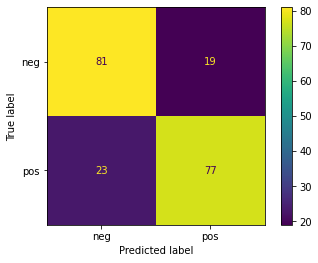

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_pred= y_pred_test, y_true= y_test))
print("===========================================================")
a = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test), display_labels=["neg", "pos"])
a.plot()

Mirem la importància de les labels en el nou model

In [20]:
importances = rf.feature_importances_

# Crear un DataFrame con las importancias de las características
df_importances = pd.DataFrame({'feature': features, 'importance': importances})

# Ordenar el DataFrame por importancia descendente
df_importances = df_importances.sort_values('importance', ascending=False)

print(df_importances)

        feature  importance
6           bad    0.056992
65         life    0.019883
30         film    0.019224
41        great    0.017703
83        movie    0.017414
..          ...         ...
82         move    0.003895
9       believe    0.003838
79         mind    0.003819
52  interesting    0.003781
69         long    0.003691

[139 rows x 2 columns]


Com es pot observar, Hem reduit, en unes 60 paraules la quantitat de paraules a tenir en compte a l'hora de classificar els diferents textos. A més a més, hem aconseguit la mateixa accuracy que en l'anterior model tenint menys labels, per tant, s'ha reduit la dimensionalitat adequadament.

Com es pot observar, al reduir les variables, augmenten les importàncies de les labels en el model, on la més important segueix sent **bad**.

Si s'observa el report de classificcació, es pot observar com per la classe negatiu tenim més precissió que la positiva, això pot ser degut a la paraula "bad", que ajuda a la precisió de la negativa però pot ser existeixen exemples que no la tenen i per tant, no arribar a reconèixer bé la classe (el nivell de recall és més inferior).

## Model no supervisat

In [21]:
fecha_str = "2023-03-29"
patron = r"\d{4}-\d{2}-\d{2}"

fecha_match = re.findall(patron, fecha_str)
fecha_match

['2023-03-29']

In [22]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

A continuació es fará diversos dataframes, on guardarem els valors positius dels sinsets i altre on hi hagi els valors negatius 

In [23]:
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')
wnl = nltk.stem.WordNetLemmatizer()
def lemmatize(p):
  d = {'NN': 'n', 'NNS': 'n', 
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a', 
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}
  if p[1] in d:
    return [wnl.lemmatize(p[0], pos=d[p[1]]), d[p[1]]]
  return [p[0]]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pelot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pelot\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [24]:
def model_no_supervisat(dades:dict):
    dd = pd.DataFrame(columns=["Exemple", "quantitat_pos", "quantitat_neg", "prediccio", "true_label"])
    for tag in dades.keys():
        exemple = nltk.word_tokenize(dades[tag])
        exemple_tagged = nltk.pos_tag(exemple)
        quant_pos = 0
        quant_neg = 0
        for x in range(len(exemple)):
            lema = lemmatize(exemple_tagged[x])
            if len(lema) == 1:
                quant_neg += 0
                quant_pos += 0
            else:
                synset = nltk.wsd.lesk(exemple, exemple[x], lema[1])
                if synset is None:
                    pass
                else:
                    senti = swn.senti_synset(synset.name())
                    quant_neg += senti.neg_score()
                    quant_pos += senti.pos_score()

        resultat = "neg" if quant_neg > quant_pos else "pos"
        dd.loc[len(dd)] = [tag] + [quant_pos] + [quant_neg] + [resultat] + [tag[0:3]]

    return dd

In [25]:
dd_train_pred = model_no_supervisat(train)

In [26]:
print(classification_report(dd_train_pred["true_label"], dd_train_pred["prediccio"]))

              precision    recall  f1-score   support

         neg       0.66      0.32      0.43       900
         pos       0.55      0.83      0.66       900

    accuracy                           0.58      1800
   macro avg       0.60      0.58      0.55      1800
weighted avg       0.60      0.58      0.55      1800



In [27]:
dd_final = model_no_supervisat(test)

In [28]:
dd_final

,Exemple,quantitat_pos,quantitat_neg,prediccio,true_label
0,neg/cv900_10800.txt,16.625,15.250,pos,neg
1,neg/cv901_11934.txt,5.750,6.875,neg,neg
2,neg/cv902_13217.txt,25.375,24.250,pos,neg
3,neg/cv903_18981.txt,10.875,7.500,pos,neg
4,neg/cv904_25663.txt,6.250,7.875,neg,neg
...,...,...,...,...,...
195,pos/cv995_21821.txt,38.875,16.125,pos,pos
196,pos/cv996_11592.txt,11.125,10.500,pos,pos
197,pos/cv997_5046.txt,30.250,32.625,neg,pos
198,pos/cv998_14111.txt,22.500,15.500,pos,pos


In [29]:
print(classification_report(dd_final["true_label"], dd_final["prediccio"]))

              precision    recall  f1-score   support

         neg       0.62      0.28      0.39       100
         pos       0.54      0.83      0.65       100

    accuracy                           0.56       200
   macro avg       0.58      0.55      0.52       200
weighted avg       0.58      0.56      0.52       200



## Experiment:
Y si li donem més pes als adjectius?

In [30]:
pesos = {"n":1, "a":3, "v":1, "r":1}

In [31]:
def model_no_supervisat(dades:dict, pesos):
    dd = pd.DataFrame(columns=["Exemple", "quantitat_pos", "quantitat_neg", "prediccio", "true_label"])
    for tag in dades.keys():
        exemple = nltk.word_tokenize(dades[tag])
        exemple_tagged = nltk.pos_tag(exemple)
        quant_pos = 0
        quant_neg = 0
        for x in range(len(exemple)):
            lema = lemmatize(exemple_tagged[x])
            if len(lema) == 1:
                pass
            else:
                synset = nltk.wsd.lesk(exemple, exemple[x], lema[1])
                if synset is None:
                    pass
                else:
                    senti = swn.senti_synset(synset.name())
                    quant_neg += senti.neg_score()*pesos[lema[1]]
                    quant_pos += senti.pos_score()*pesos[lema[1]]

        resultat = "neg" if quant_neg > quant_pos else "pos"
        dd.loc[len(dd)] = [tag] + [quant_pos] + [quant_neg] + [resultat] + [tag[0:3]]

    return dd

In [32]:
dd_test_pred = model_no_supervisat(test, pesos)

In [33]:
print(classification_report(dd_test_pred["true_label"], dd_test_pred["prediccio"]))

              precision    recall  f1-score   support

         neg       0.63      0.42      0.50       100
         pos       0.56      0.75      0.64       100

    accuracy                           0.58       200
   macro avg       0.60      0.58      0.57       200
weighted avg       0.60      0.58      0.57       200



Y si fem que els adverbis no comptin i reduim el pes tant per noms com per verbs??

In [37]:
pesos = {"n":0.2, "a":3, "v":0.2, "r":0}
dd_test_pred = model_no_supervisat(test, pesos)
print(classification_report(dd_test_pred["true_label"], dd_test_pred["prediccio"]))

              precision    recall  f1-score   support

         neg       0.64      0.49      0.55       100
         pos       0.59      0.72      0.65       100

    accuracy                           0.60       200
   macro avg       0.61      0.60      0.60       200
weighted avg       0.61      0.60      0.60       200



In [47]:
pesos = {"n":0.2, "a":3, "v":0.3, "r":0.2}
dd_test_pred = model_no_supervisat(train, pesos)
print(classification_report(dd_test_pred["true_label"], dd_test_pred["prediccio"]))

              precision    recall  f1-score   support

         neg       0.65      0.51      0.57       900
         pos       0.59      0.72      0.65       900

    accuracy                           0.61      1800
   macro avg       0.62      0.61      0.61      1800
weighted avg       0.62      0.61      0.61      1800

